# Advection-diffusion of tracer by cellular flow


An example demonstrating the advection-diffusion of a tracer by a cellular flow.

## Install dependencies

First let's make sure we have all required packages installed.

```julia
using Pkg
pkg"add PassiveTracerFlows, CairoMakie, Printf"
```

## Let's begin
Let's load `PassiveTracerFlows.jl` and some other needed packages.

In [1]:
using PassiveTracerFlows, CairoMakie, Printf

## Choosing a device: CPU or GPU

In [2]:
dev = CPU()     # Device (CPU/GPU)
nothing # hide

## Numerical parameters and time-stepping parameters

In [3]:
     nx = 128            # 2D resolution = nx²
stepper = "RK4"          # timestepper
     dt = 0.02           # timestep
 nsteps = 800            # total number of time-steps
 nsubs  = 25             # number of time-steps for intermediate logging/plotting (nsteps must be multiple of nsubs)
nothing # hide

## Numerical parameters and time-stepping parameters

In [4]:
Lx = 2π       # domain size
κ = 0.002     # diffusivity
nothing # hide

## Set up cellular flow
We create a two-dimensional grid to construct the cellular flow. Our cellular flow is derived
from a streamfunction $ψ(x, y) = ψ₀ \cos(x) \cos(y)$ as $(u, v) = (-∂_y ψ, ∂_x ψ)$.
The cellular flow is then passed into the `TwoDAdvectingFlow` constructor with `steadyflow = true`
to indicate that the flow is not time dependent.

In [5]:
grid = TwoDGrid(dev; nx, Lx)

ψ₀ = 0.2
mx, my = 1, 1

ψ = [ψ₀ * cos(mx * grid.x[i]) * cos(my * grid.y[j]) for i in 1:grid.nx, j in 1:grid.ny]

uvel(x, y) =  ψ₀ * my * cos(mx * x) * sin(my * y)
vvel(x, y) = -ψ₀ * mx * sin(mx * x) * cos(my * y)
advecting_flow = TwoDAdvectingFlow(; u = uvel, v = vvel, steadyflow = true)
nothing # hide

## Problem setup
We initialize a `Problem` by providing a set of keyword arguments.

In [6]:
prob = TracerAdvectionDiffusion.Problem(dev, advecting_flow; nx, Lx, κ, dt, stepper)
nothing # hide

and define some shortcuts

In [7]:
sol, clock, vars, params, grid = prob.sol, prob.clock, prob.vars, prob.params, prob.grid
x, y = grid.x, grid.y
nothing # hide

## Setting initial conditions

Our initial condition for the tracer $c$ is a gaussian centered at $(x, y) = (L_x/5, 0)$.

In [8]:
gaussian(x, y, σ) = exp(-(x^2 + y^2) / (2σ^2))

amplitude, spread = 0.5, 0.15
c₀ = [amplitude * gaussian(x[i] - 0.2 * grid.Lx, y[j], spread) for i=1:grid.nx, j=1:grid.ny]

TracerAdvectionDiffusion.set_c!(prob, c₀)
nothing # hide

## Time-stepping the `Problem` forward

We want to step the `Problem` forward in time and, whilst doing so, we'd like
to produce an animation of the tracer concentration.

First we create a figure using [`Observable`](https://makie.juliaplots.org/stable/documentation/nodes/)s.

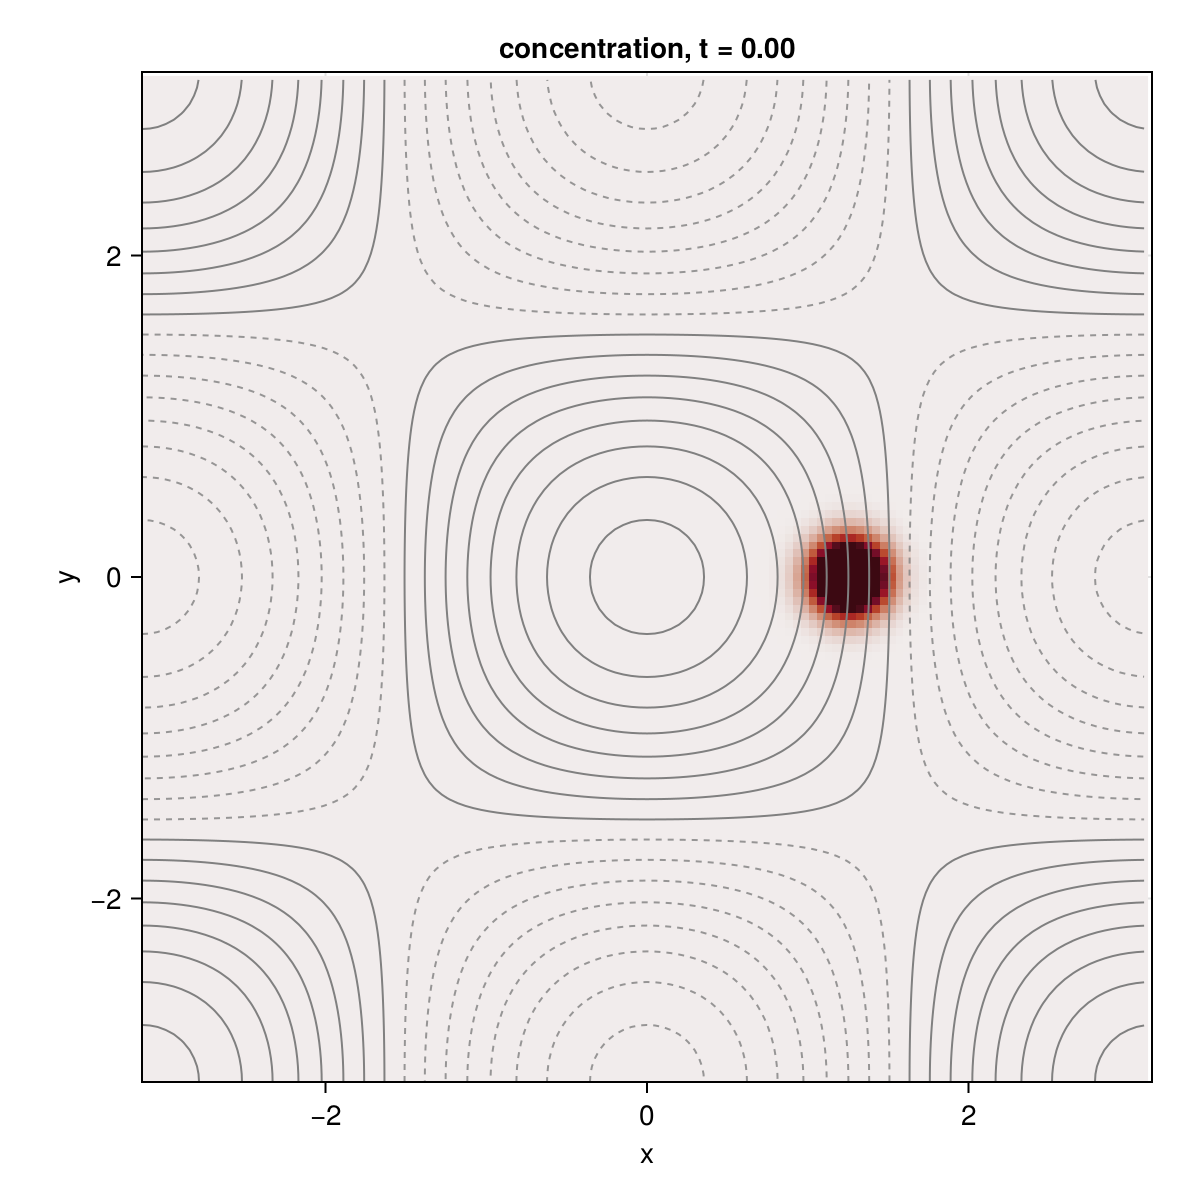

In [9]:
c_anim = Observable(Array(vars.c))
title = Observable(@sprintf("concentration, t = %.2f", clock.t))

Lx, Ly = grid.Lx, grid.Ly

fig = Figure(size = (600, 600))

ax = Axis(fig[1, 1],
          xlabel = "x",
          ylabel = "y",
          aspect = 1,
          title = title,
          limits = ((-Lx/2, Lx/2), (-Ly/2, Ly/2)))

hm = heatmap!(ax, x, y, c_anim;
              colormap = :balance, colorrange = (-0.2, 0.2))

contour!(ax, x, y, ψ;
         levels =  0.0125:0.025:0.2, color = :grey, linestyle = :solid)
contour!(ax, x, y, ψ;
         levels = -0.1875:0.025:-0.0125, color = (:grey, 0.8), linestyle = :dash)

fig

Now we time-step `Problem` and update the `c_anim` and `title` observables as we go
to create an animation.

In [10]:
startwalltime = time()

frames = 0:round(Int, nsteps/nsubs)
record(fig, "cellularflow_advection-diffusion.mp4", frames, framerate = 12) do j
   if j % (200 / nsubs) == 0
      log = @sprintf("step: %04d, t: %d, walltime: %.2f min",
                     clock.step, clock.t, (time()-startwalltime)/60)

      println(log)
    end

  c_anim[] = vars.c
  title[] = @sprintf("concentration, t = %.2f", clock.t)

  stepforward!(prob, nsubs)
  TracerAdvectionDiffusion.updatevars!(prob)
end

step: 0000, t: 0, walltime: 0.00 min
step: 0200, t: 4, walltime: 0.05 min
step: 0400, t: 8, walltime: 0.05 min
step: 0600, t: 12, walltime: 0.06 min
step: 0800, t: 16, walltime: 0.06 min


"cellularflow_advection-diffusion.mp4"

![](cellularflow_advection-diffusion.mp4)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*